In [1193]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, plot_roc_curve, make_scorer
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight

%matplotlib inline

In [1074]:
seed  = 12132707
np.random.seed(seed)

In [1194]:
survey_df.shape

(70006, 578)

In [65]:
survey_df = pd.concat([pd.read_csv("data/processed/ProcessedSurveyDataWithID_%d.csv" % i) for i in range(2020,2023)])

In [66]:
SURVEY_YEAR = "SurveyYear"
TITLE = "CurrentTitle"

In [67]:
survey_df.loc[survey_df["CurrentTitle"].isin(["Machine Learning/ MLops Engineer", "Machine Learning Engineer"]), "CurrentTitle"] = "Machine Learning Engineer"
survey_df.loc[survey_df["CurrentTitle"].isin(["Data Analyst", "Business Analyst", "Data Analyst (Business, Marketing, Financial, Quantitative, etc)"]), "CurrentTitle"] = "Data Analyst"

In [68]:
CLASSES = ["Research Scientist", "Data Scientist", "Data Analyst", "Machine Learning Engineer", "Data Engineer"]
CLASSES_FILTER = survey_df[TITLE].isin(CLASSES)

In [69]:
def year_filter(years=[2022]):
    return survey_df[SURVEY_YEAR].isin(years)

## Feature Engineering
- Age (Numeric?)
- Country (Categorical)
- MOOCLearning (#Platforms used - Numeric)
- UniversityCourse (bool)
- Highest Education (Cat)
- Research (Should use only 2022 data for this ?) - Figure out
- Programming Experience (Numeric)
- PythonUsed?
- SQL Used?
- R Used?
- Number of Programming Languages used (numeric)
- IDEs Used
- #HostedNBsUsed
- VizInPython
- VizInR
- #VizLibraries
- ML Exposure
- MLFrameworks
- #CV ALgos
- #NLP Algos
- TransferLearningDegree
- InvestmentInML
- AWS
- GCP
- Azure
- #CloudProviders
- ExperienceWithCloudCompute
- ExperienceWithCloudStorage
- ExperienceWithRelationalDB
- ExperienceWithNonRelationalDB
- ExperienceWithBITools
- PowerBI
- Tableau
- ExperienceWithMLaas
- ExperienceWithAutoML
- ExperienceWithMLDeploymentTools
- ExperienceWithMLMonitoringTools
- ResponsibleAI
- GPUUsed
- TPUUsageFrequecy
- ExperienceWithSpecializedhardware
- EngagementWithDSMedia
- ExperiencePipelineAutomation

#### Helper Functions

In [81]:
def get_col_names(df, include_kws, exclude_kws):
    """
    Return the column names that match any of include_kw and none of the exclude_kw
    """
    res_cols = []
    for col in df.columns:
        inc = False
        for include_kw in include_kws:
            inc = inc or (include_kw in col)
        exc = False
        for exclude_kw in exclude_kws:
            exc = exc or (exclude_kw in col)
        if inc and (not exc):
            res_cols.append(col)
    return res_cols

In [93]:
def add_col_to_df1(df1, df2, col_name, new_col_name, identifier="PID"):
    res = pd.merge(df1, df2[[identifier, col_name]], on=identifier, how="inner")
    res = res.rename({col_name: new_col_name}, axis=1)
    return res

In [95]:
def get_frequency_feature_in_df1(df1, df2, cols, new_col_name, identifier="PID"):
    df2 = df2.copy()
    df2["AggCol"] = df2[cols].sum(axis=1)
    res = add_col_to_df1(df1, df2[[identifier, "AggCol"]], "AggCol", new_col_name)
    del df2
    return res

In [97]:
adf = survey_df.loc[CLASSES_FILTER, ["PID", TITLE, "Age", "Country"]]

In [106]:
CATEGORICAL_FEATURES = ["Age"]
BINARY_FEATURES = []
NUMERICAL_FEATURES = []

<center> Feature: <b>Country (Leveraging Country Clustering from <a href="https://www.kaggle.com/code/michau96/15-factors-for-data-science-in-your-country"> Kaggle Notebook </a> )</b> </center>

In [60]:
country_cluster_mapping = {
    "AsianFuture": ['Russia', 'Egypt', 'Viet Nam', 'India', 'China', 'Nigeria', 'Pakistan', 'Indonesia', 'Bangladesh', 'Morocco', 'Iran, Islamic Republic of...', 'Tunisia'],
    "DevelopedGuards" : ['Portugal', 'Israel', 'United Kingdom of Great Britain and Northern Ireland', 'Italy', 'Spain', 'Canada', 'Australia', 'United States of America', 'Poland', 'France', 'Germany', 'Netherlands', 'United Arab Emirates', 'Japan'],
    "SouthAmericaAndOthers": ['Peru', 'Colombia', 'South Africa', 'Mexico', 'Brazil', 'Argentina', 'Chile', 'Turkey', 'Thailand', 'Taiwan', 'South Korea', 'Saudi Arabia', 'Philippines']
}

In [61]:
def get_country_cluster(country):
    for key in country_cluster_mapping.keys():
        if country in country_cluster_mapping[key]:
            return key
    return "Others"

In [52]:
get_country_cluster("Peru")

'SouthAmericaAndOthers'

In [98]:
adf["CountryClusters"] = adf["Country"].apply(lambda x:get_country_cluster(x))

In [105]:
CATEGORICAL_FEATURES.append("CountryClusters")

<center> Feature: <b>MOOC Learning Platforms</b> </center>

In [99]:
adf = add_col_to_df1(adf, survey_df, "MOOCPlatforms_University Courses (resulting in a university degree)", "CompletedUniDegree")

In [102]:
MOOC_COLS = get_col_names(survey_df, include_kws=["MOOCPlatforms_"], exclude_kws=["Other", "None"])

In [103]:
adf = get_frequency_feature_in_df1(adf, survey_df, MOOC_COLS, "NumCoursePlatforms")

In [107]:
BINARY_FEATURES.append("CompletedUniDegree")
NUMERICAL_FEATURES.append("NumCoursePlatforms")

<center> Feature: <b>Highest Education (Ordinal - Treated as numeric)</b> </center>

In [109]:
adf = add_col_to_df1(adf, survey_df, "HighestEducation", "HighestEducation")

In [145]:
enc = OrdinalEncoder(categories=[["Other", "Lower than Bachelor", "Bachelor", "Master", "Higher than Master"]])
adf["EduOrdinal"] = enc.fit_transform(adf["HighestEducation"].to_numpy().reshape(-1,1))

In [164]:
NUMERICAL_FEATURES.append("EduOrdinal")

<center> Feature: <b>Programming Experience (Ordinal - Treated as Numeric)</b> </center>

In [158]:
adf = add_col_to_df1(adf, survey_df, "Programming Experience", "Programming Experience")

In [160]:
adf["Programming Experience"] = adf["Programming Experience"].fillna('I have never written code')

In [162]:
enc = OrdinalEncoder(categories=[['I have never written code', '< 1 years', '1-2 years', '1-3 years', '3-5 years', '5-10 years', '10-20 years', '20+ years']])
adf["ProgExpOrdinal"] = enc.fit_transform(adf["Programming Experience"].to_numpy().reshape(-1,1))

In [165]:
NUMERICAL_FEATURES.append("ProgExpOrdinal")

<center> Feature: <b>Programming Languages</b> </center>

In [167]:
adf = add_col_to_df1(adf, survey_df, "ProgLanguage_Python", "UsedPython")
adf = add_col_to_df1(adf, survey_df, "ProgLanguage_R", "UsedR")
adf = add_col_to_df1(adf, survey_df, "ProgLanguage_SQL", "UsedSQL")

In [169]:
BINARY_FEATURES.extend(["UsedPython", "UsedR", "UsedSQL"])

In [173]:
PROGLANG_COLS = get_col_names(survey_df, include_kws=["ProgLanguage_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, PROGLANG_COLS, "NumProgLanguages")

In [175]:
NUMERICAL_FEATURES.append("NumProgLanguages")

<center> Feature: <b>IDEs</b> </center>

In [ ]:
survey_df["JupyterUsage"] = survey_df[get_col_names(survey_df, include_kws=["IDE_Jupyter"], exclude_kws=["Other", "None"])].fillna(0).sum(axis=1)
survey_df.loc[survey_df["JupyterUsage"]==2, "JupyterUsage"] = 1

In [189]:
adf = add_col_to_df1(adf, survey_df, "JupyterUsage", "UsedJupyter")

In [191]:
BINARY_FEATURES.extend(["UsedJupyter"])

In [192]:
IDE_COLS = get_col_names(survey_df, include_kws=["IDE_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, IDE_COLS, "NumIDEsUsed")

<center> Feature: <b>Visualization Experience</b> </center>

In [202]:
PYTHON_VIZ_COLNAMES = get_col_names(survey_df, include_kws=["VizLib_Altair", "VizLib_Bokeh", "VizLib_Geoplotlib", "VizLib_Matplotlib", "VizLib_Plotly", "VizLib_Seaborn", "VizLib_Pygal"], exclude_kws=["Other", "None"])
JS_VIZ_COLNAMES = get_col_names(survey_df, include_kws=["VizLib_D3 js"], exclude_kws=["Other", "None"])
R_VIZ_COLNAMES = get_col_names(survey_df, include_kws=["VizLib_Dygraphs", "VizLib_Ggplot", "VizLib_Highchart", "VizLib_Shiny"], exclude_kws=["Other", "None"])

In [207]:
survey_df["PyVizUsage"] = survey_df[PYTHON_VIZ_COLNAMES].fillna(0).sum(axis=1)
survey_df.loc[survey_df["PyVizUsage"]>1, "PyVizUsage"] = 1

survey_df["RVizUsage"] = survey_df[R_VIZ_COLNAMES].fillna(0).sum(axis=1)
survey_df.loc[survey_df["RVizUsage"]>1, "RVizUsage"] = 1

survey_df["JSVizUsage"] = survey_df[JS_VIZ_COLNAMES].fillna(0).sum(axis=1)
survey_df.loc[survey_df["JSVizUsage"]>1, "JSVizUsage"] = 1

In [210]:
adf = add_col_to_df1(adf, survey_df, "PyVizUsage", "UsedPyViz")
adf = add_col_to_df1(adf, survey_df, "RVizUsage", "UsedRViz")
adf = add_col_to_df1(adf, survey_df, "JSVizUsage", "UsedJSViz")

In [212]:
BINARY_FEATURES.extend(["UsedPyViz", "UsedRViz", "UsedJSViz"])

<center> Feature: <b>ML Exposure</b> </center>

In [226]:
adf["MLExposure"].unique()

array(['1-2 years', '3-4 years', 'I do not use machine learning methods',
       '2-3 years', 'Under 1 year', '4-5 years', '5-10 years',
       '20 or more years', '10-20 years'], dtype=object)

In [227]:
adf = add_col_to_df1(adf, survey_df, "MLExposure", "MLExposure")
adf["MLExposure"] = adf["MLExposure"].fillna('I do not use machine learning methods')

enc = OrdinalEncoder(categories=[['I do not use machine learning methods', 'Under 1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-20 years', '20 or more years']])
adf["MLExpOrdinal"] = enc.fit_transform(adf["MLExposure"].to_numpy().reshape(-1,1))

In [229]:
NUMERICAL_FEATURES.append("MLExpOrdinal")

<center> Feature: <b>ML Frameworks</b> </center>

In [232]:
adf = add_col_to_df1(adf, survey_df, "MLFramework_Scikit-learn", "UsedSKlearn")

In [233]:
survey_df["TFKerasUsage"] = survey_df[['MLFramework_TensorFlow','MLFramework_Keras']].fillna(0).sum(axis=1)
survey_df.loc[survey_df["TFKerasUsage"]>1, "TFKerasUsage"] = 1
adf = add_col_to_df1(adf, survey_df, "TFKerasUsage", "UsedTFKeras")

In [235]:
survey_df["PyTorchUsage"] = survey_df[['MLFramework_PyTorch','MLFramework_PyTorch Lightning']].fillna(0).sum(axis=1)
survey_df.loc[survey_df["PyTorchUsage"]>1, "PyTorchUsage"] = 1
adf = add_col_to_df1(adf, survey_df, "PyTorchUsage", "UsedPyTorch")

In [236]:
adf = add_col_to_df1(adf, survey_df, "MLFramework_Huggingface", "UsedHF")

In [237]:
adf = add_col_to_df1(adf, survey_df, "MLFramework_Fast.ai", "UsedFastAI")

In [238]:
BINARY_FEATURES.extend(["UsedSKlearn", "UsedTFKeras", "UsedPyTorch", "UsedHF", "UsedFastAI"])

In [239]:
MLFRAMEWORK_COLS = get_col_names(survey_df, include_kws=["MLFramework_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, MLFRAMEWORK_COLS, "NumMLFrameworks")

In [240]:
NUMERICAL_FEATURES.append("NumMLFrameworks")

<center> Feature: <b>ML Algorithms</b> </center>

In [241]:
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Linear or Logistic Regression", "UsedLinearModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Decision Trees or Random Forests", "UsedTreeModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Gradient Boosting Machines (xgboost, lightgbm, etc)", "UsedGBModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Bayesian Approaches", "UsedBayesianModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Evolutionary Approaches", "UsedEvolutionaryModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Dense Neural Networks (MLPs, etc)", "UsedNNModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Convolutional Neural Networks", "UsedCNNModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Generative Adversarial Networks", "UsedGANModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Transformer Networks (BERT, gpt-3, etc)", "UsedTransformerModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Autoencoder Networks (DAE, VAE, etc)", "UsedAEModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Recurrent Neural Networks", "UsedRNNModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Graph Neural Networks", "UsedGraphModels")

In [242]:
BINARY_FEATURES.extend(["UsedLinearModels","UsedTreeModels","UsedGBModels","UsedBayesianModels","UsedEvolutionaryModels","UsedNNModels","UsedCNNModels","UsedGANModels","UsedTransformerModels","UsedAEModels","UsedRNNModels","UsedGraphModels"])

<center> Feature: <b>Transfer Learning</b> </center>

In [244]:
PRETRAINED_COLS = get_col_names(survey_df, include_kws=["DownloadPreTrainedWeights_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, PRETRAINED_COLS, "NumTransferLearning")

In [245]:
NUMERICAL_FEATURES.append("NumTransferLearning")

<center> Feature: <b>CloudProviders</b> </center>

In [249]:
adf = add_col_to_df1(adf, survey_df, "CloudProviderUsed_Google Cloud Platform (GCP)", "UsedGCP")
adf = add_col_to_df1(adf, survey_df, "CloudProviderUsed_Amazon Web Services (AWS)", "UsedAWS")
adf = add_col_to_df1(adf, survey_df, "CloudProviderUsed_Microsoft Azure", "UsedAzure")

In [250]:
BINARY_FEATURES.extend(["UsedGCP", "UsedAWS", "UsedAzure"])

In [251]:
CLOUDPROVIDER_COLS = get_col_names(survey_df, include_kws=["CloudProviderUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, CLOUDPROVIDER_COLS, "NumCloudProvidersUsed")

In [252]:
NUMERICAL_FEATURES.append("NumCloudProvidersUsed")

<center> Feature: <b>CloudCompute</b> </center>

In [253]:
CLOUDCOMPUTE_COLS = get_col_names(survey_df, include_kws=["CloudComputeUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, CLOUDCOMPUTE_COLS, "NumCloudComputeUsed")
NUMERICAL_FEATURES.append("NumCloudComputeUsed")

<center> Feature: <b>CloudStorage</b> </center>

In [1196]:
NUMERICAL_FEATURES

['NumCoursePlatforms',
 'EduOrdinal',
 'ProgExpOrdinal',
 'NumProgLanguages',
 'MLExpOrdinal',
 'NumMLFrameworks',
 'NumTransferLearning',
 'NumCloudProvidersUsed',
 'NumCloudComputeUsed',
 'NumCloudStorageUsed',
 'NumBIToolsUsed',
 'NumMLaaSToolsUsed',
 'NumAutoMLUsed',
 'NumMLDeploymentToolsUsed',
 'NumMLMonitoringToolUsed',
 'NumHardwareUsed',
 'TPUUsageOrdinal',
 'NumDSContentMediaConsumed',
 'NumStepsOfPipelineAutomated']

In [254]:
CLOUDSTORAGE_COLS = get_col_names(survey_df, include_kws=["CloudStorageUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, CLOUDSTORAGE_COLS, "NumCloudStorageUsed")
NUMERICAL_FEATURES.append("NumCloudStorageUsed")

<center> Feature: <b>DBUSed</b> </center>

In [483]:
OG_BINARY_COLS = [col for col in survey_df.columns if survey_df[col].isin([0,1,"0","1"]).all()]

In [458]:
DBUsed_COLS

['DBUsed_MySQL',
 'DBUsed_PostgreSQL',
 'DBUsed_SQLite',
 'DBUsed_Oracle Database',
 'DBUsed_MongoDB',
 'DBUsed_Snowflake',
 'DBUsed_IBM Db2',
 'DBUsed_Microsoft SQL Server',
 'DBUsed_Microsoft Azure SQL Database',
 'DBUsed_Amazon Redshift',
 'DBUsed_Amazon RDS',
 'DBUsed_Amazon DynamoDB',
 'DBUsed_Google Cloud BigQuery',
 'DBUsed_Google Cloud SQL',
 'DBUsed_Microsoft Azure Cosmos DB',
 'DBUsed_Amazon Aurora',
 'DBUsed_Google Cloud Firestore',
 'DBUsed_Google Cloud BigTable',
 'DBUsed_Google Cloud Spanner',
 'DBUsed_PostgresSQL',
 'DBUsed_Microsoft Access',
 'DBUsed_Microsoft Azure Data Lake Storage',
 'DBUsed_Amazon Athena']

In [451]:
DBUsed_COLS = get_col_names(survey_df, include_kws=["DBUsed_"], exclude_kws=["Other", "None"])

In [256]:
rel_db_map = {
    "Relational": ,
    "Non-relational": 
}

In [257]:
def get_db_type(db):
    for key in rel_db_map.keys():
        if db in rel_db_map[key]:
            return key
    return "Others"

In [261]:
RELATIONAL_DBS = ["DBUsed_Microsoft Access","DBUsed_Google Cloud Spanner","DBUsed_Amazon Aurora","DBUsed_Microsoft Azure Cosmos DB","DBUsed_Google Cloud SQL","DBUsed_Google Cloud BigQuery","DBUsed_Amazon RDS","DBUsed_Amazon Redshift","DBUsed_Snowflake", "DBUsed_IBM Db2", "DBUsed_Microsoft SQL Server", "DBUsed_Microsoft Azure SQL Database","DBUsed_MySQL", "DBUsed_PostgreSQL", "DBUsed_PostgresSQL", "DBUsed_SQLite", 'DBUsed_Oracle Database']
NON_RELATIONAL_DBS = ["DBUsed_Google Cloud BigTable","DBUsed_Google Cloud Firestore","DBUsed_Microsoft Azure Cosmos DB","DBUsed_Amazon DynamoDB","DBUsed_MongoDB"]

In [270]:
survey_df["UsedRelationalDBs"] = survey_df[RELATIONAL_DBS].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)
survey_df["UsedNonRelationalDBs"] = survey_df[NON_RELATIONAL_DBS].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [271]:
adf = add_col_to_df1(adf, survey_df, "UsedRelationalDBs", "UsedRelationalDBs")
adf = add_col_to_df1(adf, survey_df, "UsedNonRelationalDBs", "UsedNonRelationalDBs")

In [272]:
BINARY_FEATURES.extend(["UsedRelationalDBs","UsedNonRelationalDBs"])

In [460]:
survey_df["UsedPostgresDBs"] = survey_df[["DBUsed_PostgreSQL","DBUsed_PostgresSQL"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [461]:
adf = add_col_to_df1(adf, survey_df, "UsedPostgresDBs", "UsedPostgresDBs")

In [463]:
adf = add_col_to_df1(adf, survey_df, "DBUsed_Microsoft SQL Server", "UsedSQLServer")

In [464]:
BINARY_FEATURES.extend(["UsedPostgresDBs","UsedSQLServer"])

<center> Feature: <b>BI Tools</b> </center>

In [273]:
survey_df["UsedTableau"] = survey_df[["BIToolUsed_Tableau", "BIToolUsed_Tableau CRM"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [274]:
adf = add_col_to_df1(adf, survey_df, "BIToolUsed_Microsoft Power BI", "UsedPowerBI")
adf = add_col_to_df1(adf, survey_df, "UsedTableau", "UsedTableau")

In [275]:
BINARY_FEATURES.extend(["UsedPowerBI","UsedTableau"])

In [276]:
BI_COLS = get_col_names(survey_df, include_kws=["BIToolUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, BI_COLS, "NumBIToolsUsed")

In [277]:
NUMERICAL_FEATURES.append("NumBIToolsUsed")

<center> Features: <b>MLaaS, AutoML, Deployment, Monitoring Tools</b> </center>

In [ ]:
survey_df["MLMonitoringToolUsed_"]

In [279]:
COLS = get_col_names(survey_df, include_kws=["MLaaS_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumMLaaSToolsUsed")
NUMERICAL_FEATURES.append("NumMLaaSToolsUsed")

In [296]:
COLS = get_col_names(survey_df, include_kws=["AutoMLUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumAutoMLUsed")
NUMERICAL_FEATURES.append("NumAutoMLUsed")

In [281]:
COLS = get_col_names(survey_df, include_kws=["MLDeploymentToolsUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumMLDeploymentToolsUsed")
NUMERICAL_FEATURES.append("NumMLDeploymentToolsUsed")

In [282]:
COLS = get_col_names(survey_df, include_kws=["MLMonitoringToolUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumMLMonitoringToolUsed")
NUMERICAL_FEATURES.append("NumMLMonitoringToolUsed")

<center> Feature: <b>Hardware</b> </center>

In [285]:
survey_df["DSContentMediaConsumed_"].unique()

array(['2-5 times', 'Never', nan, '6-25 times', 'Once',
       'More than 25 times'], dtype=object)

In [283]:
survey_df["UsedGPU"] = survey_df[["HardwareUsed_GPUs", "HardwareUsed_NVIDIA GPUs"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [286]:
adf = add_col_to_df1(adf, survey_df, "UsedGPU", "UsedGPU")

In [287]:
BINARY_FEATURES.extend(["UsedGPU"])

In [288]:
adf = add_col_to_df1(adf, survey_df, "TPUUsageFrequency", "TPUUsageFrequency")

In [289]:
adf["TPUUsageFrequency"] = adf["TPUUsageFrequency"].fillna('Never')

enc = OrdinalEncoder(categories=[['Never', 'Once', '2-5 times', '6-25 times', 'More than 25 times']])
adf["TPUUsageOrdinal"] = enc.fit_transform(adf["TPUUsageFrequency"].to_numpy().reshape(-1,1))

In [290]:
COLS = get_col_names(survey_df, include_kws=["HardwareUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumHardwareUsed")
NUMERICAL_FEATURES.append("NumHardwareUsed")

In [291]:
NUMERICAL_FEATURES.append("TPUUsageOrdinal")

<center> Feature: <b>DSMedia</b> </center>

In [292]:
COLS = get_col_names(survey_df, include_kws=["DSContentMediaConsumed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumDSContentMediaConsumed")
NUMERICAL_FEATURES.append("NumDSContentMediaConsumed")

<center> Feature: <b>PipelineAutomation</b> </center>

In [303]:
survey_df["UsedE2EPipelineAutomation"] = survey_df[["AutoMLFrameworksUsed_Automation of full ML pipelines (e.g. Google AutoML, H2O Driverless AI)", "AutoMLFrameworksUsed_Automation of full ML pipelines (e.g. Google AutoML, H20 Driverless AI)"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [297]:
COLS = get_col_names(survey_df, include_kws=["AutoMLFrameworksUsed_Automated"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumStepsOfPipelineAutomated")
NUMERICAL_FEATURES.append("NumStepsOfPipelineAutomated")

In [304]:
adf = add_col_to_df1(adf, survey_df, "UsedE2EPipelineAutomation", "UsedE2EPipelineAutomation")
BINARY_FEATURES.extend(["UsedE2EPipelineAutomation"])

In [403]:
adf[["PID",TITLE]+CATEGORICAL_FEATURES+NUMERICAL_FEATURES+BINARY_FEATURES].fillna(0).to_csv("data/processed/DS-MLE-DA-DE-RS-FeatureEngineered.csv", index=False)

In [1043]:
pd.merge(adf[adf["Country"]=="United States of America"], survey_df[["PID", "AnnualComp(USD)"]], how="left", on="PID").dropna(subset="AnnualComp(USD)")

,PID,CurrentTitle,Age,Country,CountryClusters,CompletedUniDegree,NumCoursePlatforms,HighestEducation,EduOrdinal,Programming Experience,...,TPUUsageFrequency,TPUUsageOrdinal,NumHardwareUsed,NumDSContentMediaConsumed,NumAutoMLUsed,NumStepsOfPipelineAutomated,UsedE2EPipelineAutomation,UsedPostgresDBs,UsedSQLServer,AnnualComp(USD)
0,2_2020,Data Engineer,30-34,United States of America,DevelopedGuards,0,3,Master,3.00,5-10 years,...,2-5 times,2.00,1.00,7,0.00,0.00,0,1,0,"100,000-124,999"
1,4_2020,Data Scientist,30-34,United States of America,DevelopedGuards,1,4,Master,3.00,5-10 years,...,2-5 times,2.00,0.00,0,0.00,0.00,0,0,0,"125,000-149,999"
2,12_2020,Research Scientist,35-39,United States of America,DevelopedGuards,0,0,Higher than Master,4.00,1-2 years,...,Never,0.00,0.00,2,0.00,0.00,0,0,0,"30,000-39,999"
3,59_2020,Data Analyst,35-39,United States of America,DevelopedGuards,0,5,Higher than Master,4.00,1-2 years,...,Once,1.00,1.00,2,0.00,0.00,0,0,1,"70,000-79,999"
5,120_2020,Data Scientist,35-39,United States of America,DevelopedGuards,1,1,Master,3.00,5-10 years,...,Never,0.00,0.00,4,0.00,0.00,0,0,1,"100,000-124,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3011,23815_2022,Research Scientist,50-54,United States of America,DevelopedGuards,1,8,Master,3.00,10-20 years,...,2-5 times,2.00,2.00,4,1.00,0.00,0,0,0,"300,000-499,999"
3012,23819_2022,Data Engineer,25-29,United States of America,DevelopedGuards,0,2,Bachelor,2.00,1-3 years,...,6-25 times,3.00,1.00,2,0.00,0.00,0,1,1,"60,000-69,999"
3014,23833_2022,Data Scientist,30-34,United States of America,DevelopedGuards,0,4,Master,3.00,5-10 years,...,Never,0.00,0.00,4,0.00,0.00,0,0,0,"80,000-89,999"
3015,23892_2022,Data Scientist,35-39,United States of America,DevelopedGuards,0,0,Master,3.00,1-3 years,...,Never,0.00,0.00,3,0.00,0.00,0,0,0,"60,000-69,999"


<center> Modeling: <b>Classification of Title</b> </center>

In [1003]:
class_df = adf[["PID",TITLE]+CATEGORICAL_FEATURES+NUMERICAL_FEATURES+BINARY_FEATURES].fillna(0)

In [1004]:
mms = MinMaxScaler()
class_df[NUMERICAL_FEATURES] = mms.fit_transform(class_df[NUMERICAL_FEATURES])

In [926]:
from lazypredict.Supervised import LazyClassifier

In [1089]:
def top_n_accuracy(y_true, y_pred_proba, n=2):
    topn = np.argsort(y_pred_proba, axis = 1)[:,-n:]
    return np.mean(np.array([1 if y_true[k] in topn[k] else 0 for k in range(len(topn))]))

top_n_acc_score = make_scorer(top_n_accuracy, needs_proba=True)
top_n_acc_score.__name__ = "Top2Acc"

In [1090]:
X = class_df[NUMERICAL_FEATURES+BINARY_FEATURES]
le = LabelEncoder()
y = le.fit_transform(class_df[TITLE])

In [1183]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=seed)

In [1092]:
clf = LazyClassifier(verbose=1,ignore_warnings=True, custom_metric=top_n_acc_score)

In [1093]:
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████| 29/29 [01:58<00:00,  4.10s/it]


ValueError: All arrays must be of the same length

### Baseline Model: Dummy Classifier

In [1168]:
clf = DummyClassifier(strategy="prior")
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1409
           1       0.00      0.00      0.00       286
           2       0.35      1.00      0.52      1642
           3       0.00      0.00      0.00       639
           4       0.00      0.00      0.00       667

    accuracy                           0.35      4643
   macro avg       0.07      0.20      0.10      4643
weighted avg       0.13      0.35      0.18      4643



In [1169]:
top_n_acc_score(clf, X_test, y_test)

0.6571182425156149

### Decision tree classifier

In [1100]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=12132707)

In [1103]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.51      0.50      1409
           1       0.13      0.14      0.13       286
           2       0.46      0.44      0.45      1642
           3       0.25      0.26      0.26       639
           4       0.39      0.39      0.39       667

    accuracy                           0.41      4643
   macro avg       0.35      0.35      0.35      4643
weighted avg       0.41      0.41      0.41      4643



In [1105]:
top_n_acc_score(clf, X_test, y_test)

0.5190609519707086

### Random Forest

In [1185]:
clf = RandomForestClassifier(max_depth=3, random_state=seed, class_weight='balanced')
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.62      0.59      1409
           1       0.22      0.32      0.26       286
           2       0.61      0.32      0.42      1642
           3       0.32      0.49      0.39       639
           4       0.49      0.64      0.56       667

    accuracy                           0.48      4643
   macro avg       0.44      0.48      0.44      4643
weighted avg       0.52      0.48      0.48      4643



In [1186]:
top_n_acc_score(clf, X_test, y_test)

0.6900710747361619

### SVM

In [1187]:
clf = SVC(gamma='auto', random_state=seed, probability=True, class_weight='balanced')
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.59      0.54      0.56      1409
           1       0.19      0.43      0.27       286
           2       0.61      0.37      0.46      1642
           3       0.35      0.48      0.41       639
           4       0.48      0.63      0.54       667

    accuracy                           0.47      4643
   macro avg       0.44      0.49      0.45      4643
weighted avg       0.52      0.47      0.48      4643



In [1188]:
top_n_acc_score(clf, X_test, y_test)

0.7863450355373681

### KNN Classifier

In [1130]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.46      0.63      0.53      1409
           1       0.10      0.08      0.09       286
           2       0.46      0.47      0.46      1642
           3       0.29      0.17      0.21       639
           4       0.46      0.25      0.33       667

    accuracy                           0.42      4643
   macro avg       0.35      0.32      0.33      4643
weighted avg       0.41      0.42      0.41      4643



In [1131]:
top_n_acc_score(clf, X_test, y_test)

0.6263191901787637

### Multinomial Logistic Regression

In [1189]:
clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=seed, class_weight='balanced')
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.54      0.57      1409
           1       0.19      0.47      0.27       286
           2       0.62      0.37      0.46      1642
           3       0.36      0.45      0.40       639
           4       0.47      0.64      0.54       667

    accuracy                           0.48      4643
   macro avg       0.45      0.49      0.45      4643
weighted avg       0.53      0.48      0.49      4643



In [1190]:
top_n_acc_score(clf, X_test, y_test)

0.7187163471893172

### MLP

In [1153]:
def build_and_compile_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu', input_shape=(55,)),
      tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [1154]:
model = build_and_compile_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 128)               7168      
                                                                 
 dense_30 (Dense)            (None, 5)                 645       
                                                                 
Total params: 7,813
Trainable params: 7,813
Non-trainable params: 0
_________________________________________________________________


In [1155]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

In [1156]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=1, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/20


2022-12-19 22:24:52.863203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


465/465 [==============================] - ETA: 0s - loss: 1.2614

2022-12-19 22:24:55.406034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


465/465 [==============================] - 3s 6ms/step - loss: 1.2614 - val_loss: 1.2297
Epoch 2/20
465/465 [==============================] - 2s 5ms/step - loss: 1.1808 - val_loss: 1.2001
Epoch 3/20
465/465 [==============================] - 3s 6ms/step - loss: 1.1587 - val_loss: 1.1905
Epoch 4/20
465/465 [==============================] - 2s 5ms/step - loss: 1.1459 - val_loss: 1.1933
Epoch 5/20
465/465 [==============================] - 2s 5ms/step - loss: 1.1358 - val_loss: 1.1831
Epoch 6/20
465/465 [==============================] - 2s 5ms/step - loss: 1.1257 - val_loss: 1.1804
Epoch 7/20
465/465 [==============================] - 2s 5ms/step - loss: 1.1164 - val_loss: 1.1867
Epoch 8/20
465/465 [==============================] - 2s 5ms/step - loss: 1.1068 - val_loss: 1.1761
Epoch 9/20
465/465 [==============================] - 2s 5ms/step - loss: 1.1024 - val_loss: 1.1793
Epoch 10/20
465/465 [==============================] - 2s 5ms/step - loss: 1.0952 - val_loss: 1.1799
Epoch 11/2

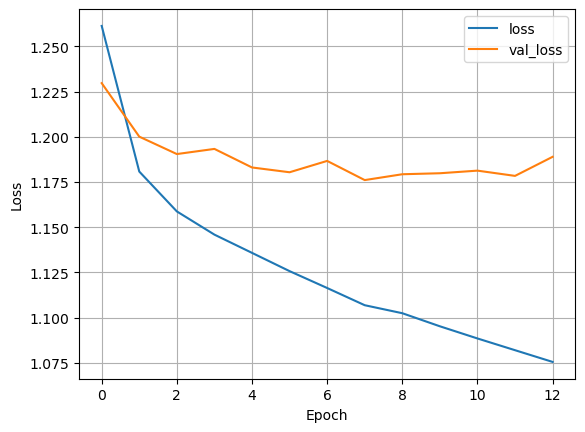

In [1157]:
plot_loss(history)

In [449]:
le.inverse_transform([0,1,2,3,4])

array(['Data Analyst', 'Data Engineer', 'Data Scientist',
       'Machine Learning Engineer', 'Research Scientist'], dtype=object)

In [1158]:
print(classification_report(y_test, np.argmax(model.predict(X_test), axis=1)))

 76/146 [==============>...............] - ETA: 0s

2022-12-19 22:25:40.159729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.58      0.67      0.62      1409
           1       0.40      0.03      0.05       286
           2       0.52      0.64      0.58      1642
           3       0.44      0.26      0.33       639
           4       0.58      0.53      0.55       667

    accuracy                           0.54      4643
   macro avg       0.51      0.43      0.43      4643
weighted avg       0.53      0.54      0.52      4643



In [1162]:
model.predict_proba = model.predict

In [1163]:
top_n_acc_score(model, X_test, y_test)

146/146 [==============================] - 0s 2ms/step


0.7880680594443248

### XGBoost

In [1191]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

clf=XGBClassifier(random_state=seed)
clf.fit(X_train, y_train, sample_weight=classes_weights)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.59      0.58      0.59      1409
           1       0.19      0.29      0.23       286
           2       0.59      0.44      0.50      1642
           3       0.35      0.46      0.40       639
           4       0.52      0.62      0.57       667

    accuracy                           0.50      4643
   macro avg       0.45      0.48      0.46      4643
weighted avg       0.53      0.50      0.51      4643



In [1192]:
top_n_acc_score(clf, X_test, y_test)

0.7493000215377988

### LGBM Classifier

In [1142]:
clf = LGBMClassifier(is_unbalance=True, random_state=seed)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.69      0.62      1409
           1       0.40      0.09      0.15       286
           2       0.55      0.60      0.57      1642
           3       0.44      0.28      0.34       639
           4       0.59      0.56      0.58       667

    accuracy                           0.55      4643
   macro avg       0.51      0.45      0.45      4643
weighted avg       0.54      0.55      0.53      4643



In [1143]:
top_n_acc_score(clf, X_test, y_test)

0.7923756192117165

### Feature Selection

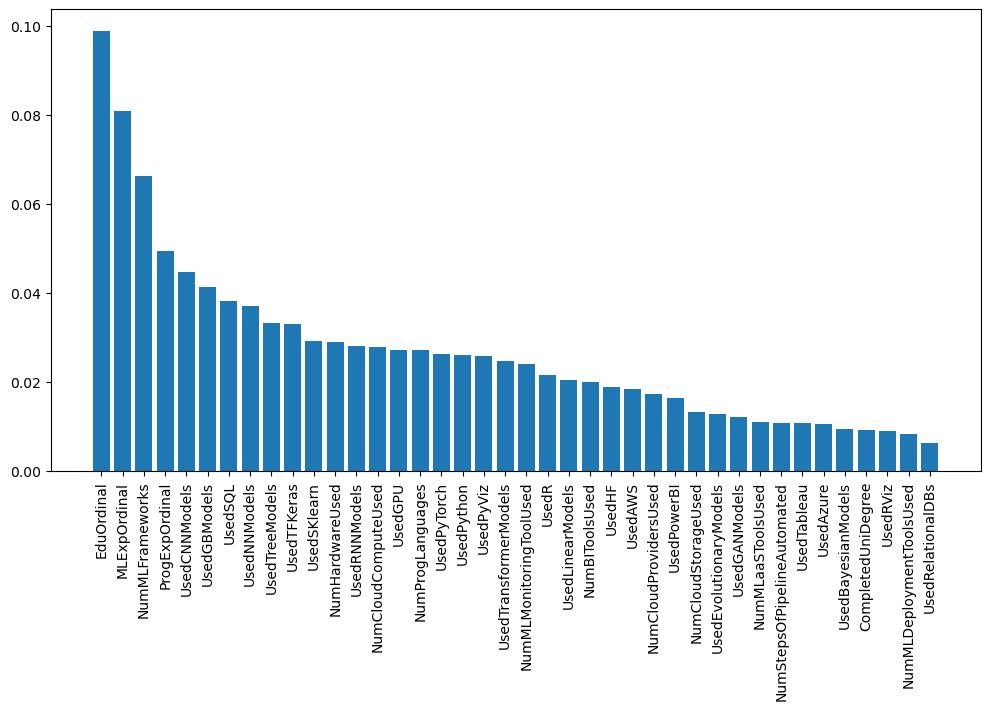

In [1144]:
fs = SelectKBest(score_func=mutual_info_classif, k=30)
fs.fit(X, y)

feat_imp = sorted(list(zip(X_train.columns, fs.scores_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

plt.figure(figsize=(12,6))
plt.bar(feat_name[:40], feat_imp_score[:40])
plt.xticks(rotation=90);

In [1176]:
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

### LGBM Classifier - Hyperparameter Tuning

In [1146]:
lightgbm = LGBMClassifier(is_unbalance=True, random_state=seed)
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [200, 400, 600, 800]
max_depth = [int(x) for x in np.linspace(1, 7, num = 7)]
subsample = [0.5, 0.75, 1.0]
colsample_bytree = [0.5, 0.75, 1.0]
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree)
clf = RandomizedSearchCV(estimator=lightgbm, param_distributions=grid, n_iter=100, scoring='accuracy', cv=3, n_jobs=1, verbose=True)
best_model = clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [1177]:
best_model.score(X_test, y_test)

0.5498600043075598

In [1178]:
best_model.best_params_

{'subsample': 0.75,
 'n_estimators': 600,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.5}

In [1179]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.70      0.63      1409
           1       0.34      0.06      0.10       286
           2       0.54      0.62      0.58      1642
           3       0.45      0.28      0.34       639
           4       0.60      0.54      0.57       667

    accuracy                           0.55      4643
   macro avg       0.50      0.44      0.44      4643
weighted avg       0.53      0.55      0.53      4643



In [1184]:
top_n_acc_score(best_model, X_test, y_test)

0.7962524230023692

In [1070]:
feat_imp = sorted(list(zip(X.columns, best_model.best_estimator_.feature_importances_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

Text(0.5, 1.0, 'Feature Importance Scores')

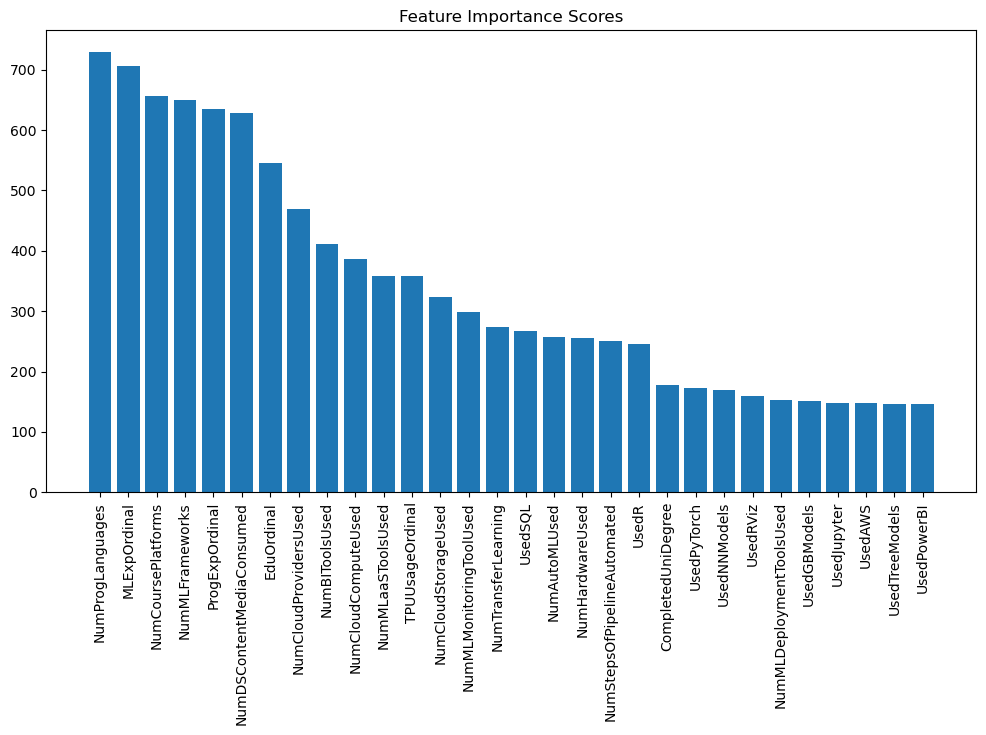

In [1072]:
plt.figure(figsize=(12,6))
plt.bar(feat_name[:30], feat_imp_score[:30])
plt.xticks(rotation=90);
plt.title("Feature Importance Scores")


#### Visualization Helper Functions

In [1066]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [1211]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations

    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes

    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''

    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.

    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.

    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).

    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

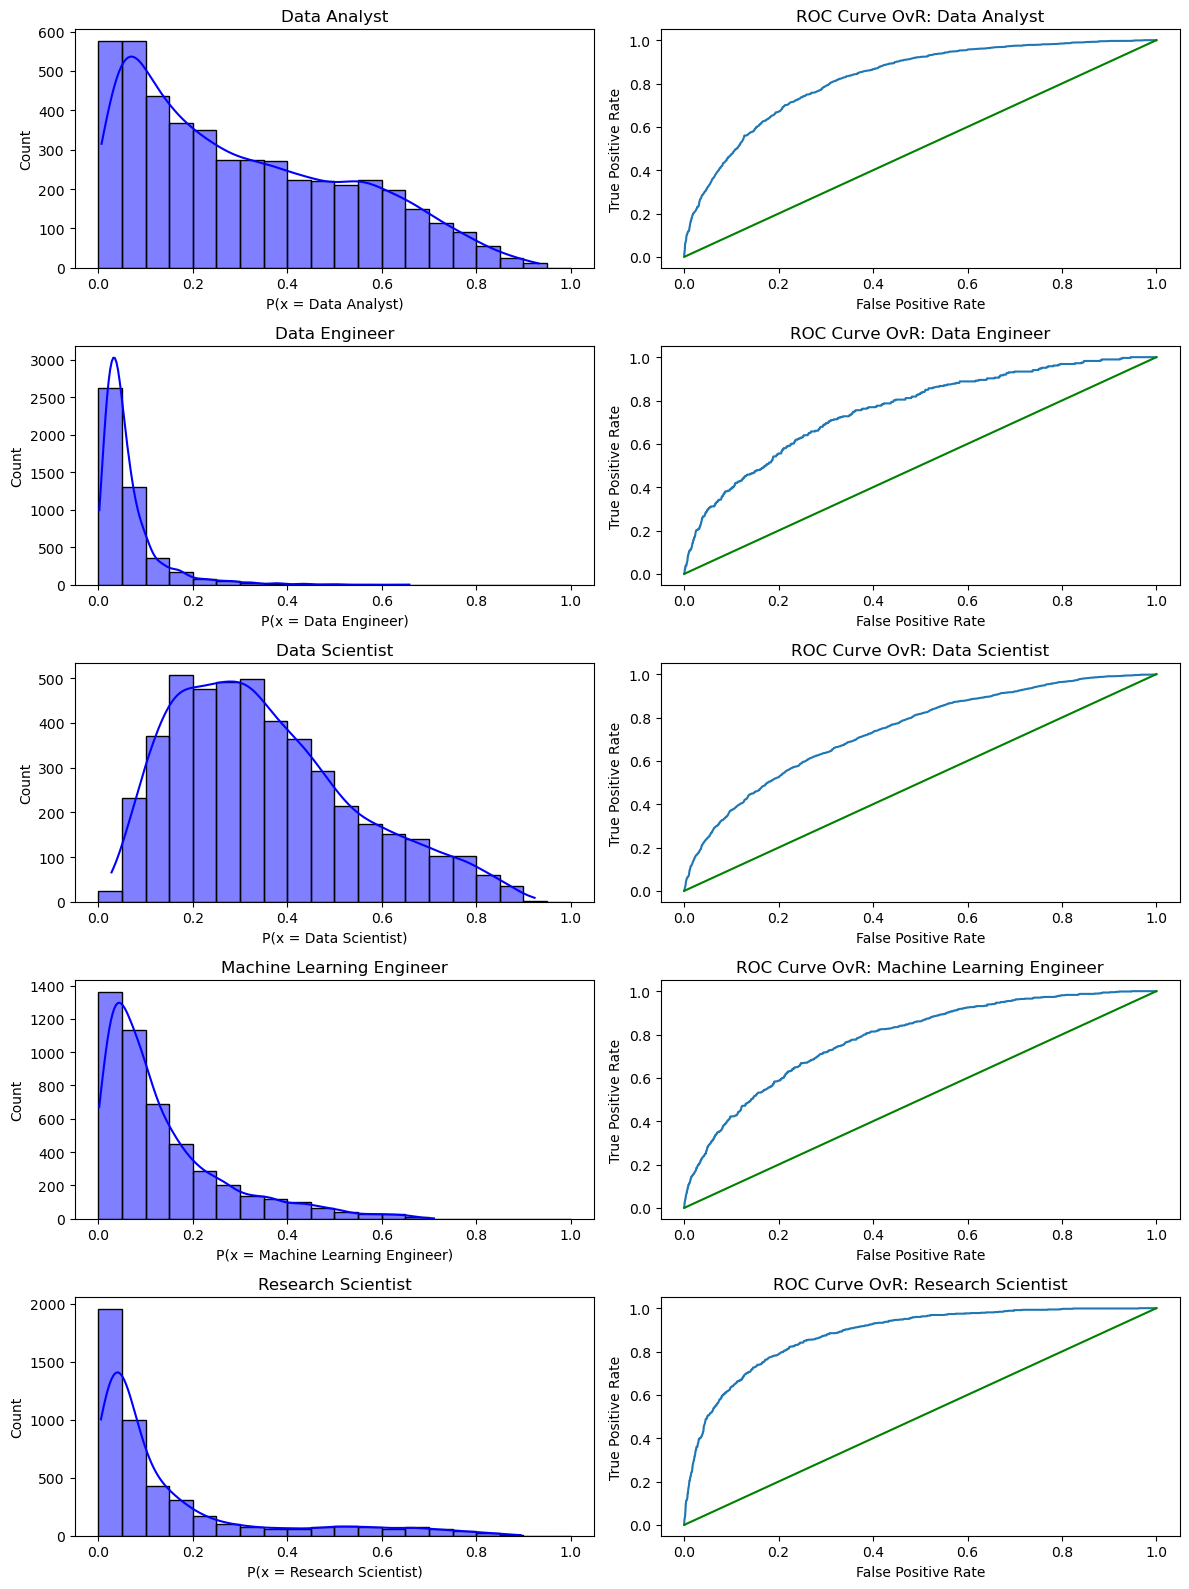

In [1216]:
plt.figure(figsize = (12, 16))
bins = [i/20 for i in range(20)] + [1]
classes = best_model.classes_
class_names = le.inverse_transform(classes)
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(5, 2, 2*i+1)
    sns.histplot(x = "prob", data = df_aux, color = 'b', ax = ax, bins = bins, kde=True)
    ax.set_title(class_names[c])
#     ax.legend([f"Class: {class_names[c]}", "Rest"])
    ax.set_xlabel(f"P(x = {class_names[c]})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(5, 2, 2*i+2)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR: "+str(class_names[c]))
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

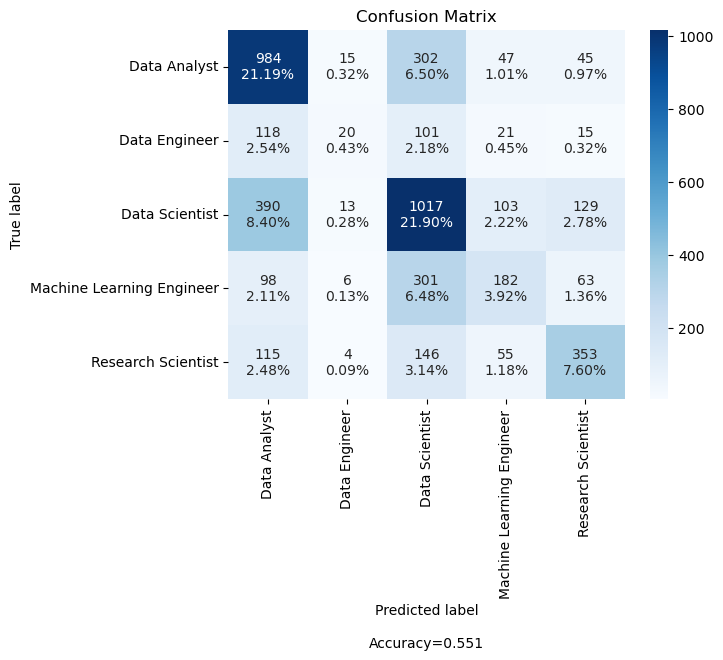

In [1073]:
make_confusion_matrix(cf_matrix, categories=class_names, title="Confusion Matrix")

### One Vs All Classifiers

In [499]:
adf2 = survey_df[CLASSES_FILTER].copy()

In [500]:
adf2["IsDataAnalyst"] = adf2["CurrentTitle"]=="Data Analyst"
adf2.groupby("IsDataAnalyst").count()

,Unnamed: 0,Duration (in seconds),Age,Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,MOOCPlatforms_DataCamp,...,RVizUsage,JSVizUsage,TFKerasUsage,PyTorchUsage,UsedRelationalDBs,UsedNonRelationalDBs,UsedTableau,UsedGPU,UsedE2EPipelineAutomation,UsedPostgresDBs
IsDataAnalyst,,,,,,,,,,,,,,,,,,,,,
False,16135,16135,16135,16135,16135,16135,16135,16135,16135,16135,...,16135,16135,16135,16135,16135,16135,16135,16135,16135,16135
True,7080,7080,7080,7080,7080,7080,7080,7080,7080,7080,...,7080,7080,7080,7080,7080,7080,7080,7080,7080,7080


In [501]:
adf2["IsDataScientist"] = adf2["CurrentTitle"]=="Data Scientist"
adf2.groupby("IsDataScientist").count()

,Unnamed: 0,Duration (in seconds),Age,Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,MOOCPlatforms_DataCamp,...,JSVizUsage,TFKerasUsage,PyTorchUsage,UsedRelationalDBs,UsedNonRelationalDBs,UsedTableau,UsedGPU,UsedE2EPipelineAutomation,UsedPostgresDBs,IsDataAnalyst
IsDataScientist,,,,,,,,,,,,,,,,,,,,,
False,14994,14994,14994,14994,14994,14994,14994,14994,14994,14994,...,14994,14994,14994,14994,14994,14994,14994,14994,14994,14994
True,8221,8221,8221,8221,8221,8221,8221,8221,8221,8221,...,8221,8221,8221,8221,8221,8221,8221,8221,8221,8221


In [502]:
adf2["IsMLE"] = adf2["CurrentTitle"]=="Machine Learning Engineer"
adf2.groupby("IsMLE").count()

,Unnamed: 0,Duration (in seconds),Age,Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,MOOCPlatforms_DataCamp,...,TFKerasUsage,PyTorchUsage,UsedRelationalDBs,UsedNonRelationalDBs,UsedTableau,UsedGPU,UsedE2EPipelineAutomation,UsedPostgresDBs,IsDataAnalyst,IsDataScientist
IsMLE,,,,,,,,,,,,,,,,,,,,,
False,20063,20063,20063,20063,20063,20063,20063,20063,20063,20063,...,20063,20063,20063,20063,20063,20063,20063,20063,20063,20063
True,3152,3152,3152,3152,3152,3152,3152,3152,3152,3152,...,3152,3152,3152,3152,3152,3152,3152,3152,3152,3152


In [503]:
adf2["IsDataEngineer"] = adf2["CurrentTitle"]=="Data Engineer"
adf2.groupby("IsDataEngineer").count()

,Unnamed: 0,Duration (in seconds),Age,Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,MOOCPlatforms_DataCamp,...,PyTorchUsage,UsedRelationalDBs,UsedNonRelationalDBs,UsedTableau,UsedGPU,UsedE2EPipelineAutomation,UsedPostgresDBs,IsDataAnalyst,IsDataScientist,IsMLE
IsDataEngineer,,,,,,,,,,,,,,,,,,,,,
False,21758,21758,21758,21758,21758,21758,21758,21758,21758,21758,...,21758,21758,21758,21758,21758,21758,21758,21758,21758,21758
True,1457,1457,1457,1457,1457,1457,1457,1457,1457,1457,...,1457,1457,1457,1457,1457,1457,1457,1457,1457,1457


In [504]:
adf2["IsResearchScientist"] = adf2["CurrentTitle"]=="Research Scientist"
adf2.groupby("IsResearchScientist").count()

,Unnamed: 0,Duration (in seconds),Age,Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,MOOCPlatforms_DataCamp,...,UsedRelationalDBs,UsedNonRelationalDBs,UsedTableau,UsedGPU,UsedE2EPipelineAutomation,UsedPostgresDBs,IsDataAnalyst,IsDataScientist,IsMLE,IsDataEngineer
IsResearchScientist,,,,,,,,,,,,,,,,,,,,,
False,19910,19910,19910,19910,19910,19910,19910,19910,19910,19910,...,19910,19910,19910,19910,19910,19910,19910,19910,19910,19910
True,3305,3305,3305,3305,3305,3305,3305,3305,3305,3305,...,3305,3305,3305,3305,3305,3305,3305,3305,3305,3305


#### Data Engineer

In [508]:
list(adf2.columns)

['Unnamed: 0',
 'Duration (in seconds)',
 'Age',
 'Gender',
 'Country',
 'IsStudent',
 'MOOCPlatforms_Coursera',
 'MOOCPlatforms_edX',
 'MOOCPlatforms_Kaggle Learn Courses',
 'MOOCPlatforms_DataCamp',
 'MOOCPlatforms_Fast.ai',
 'MOOCPlatforms_Udacity',
 'MOOCPlatforms_Udemy',
 'MOOCPlatforms_LinkedIn Learning',
 'MOOCPlatforms_Cloud-certification programs (direct from AWS, Azure, GCP, or similar)',
 'MOOCPlatforms_University Courses (resulting in a university degree)',
 'MOOCPlatforms_None',
 'MOOCPlatforms_Other',
 'IntroToDSPlatform_University courses',
 'IntroToDSPlatform_Online courses (Coursera, EdX, etc)',
 'IntroToDSPlatform_Social media platforms (Reddit, Twitter, etc)',
 'IntroToDSPlatform_Video platforms (YouTube, Twitch, etc)',
 'IntroToDSPlatform_Kaggle (notebooks, competitions, etc)',
 'IntroToDSPlatform_None / I do not study data science',
 'IntroToDSPlatform_Other',
 'HighestEducation',
 'HasPublishedResearch',
 'TheoreticalResearch',
 'AppliedResearch',
 'NonMLResearch'

In [560]:
OG_FEATURES = OG_BINARY_COLS[:-12]
X, y_de = adf2[OG_FEATURES], adf2["IsDataEngineer"]
X.shape, y_de.shape

((23215, 159), (23215,))

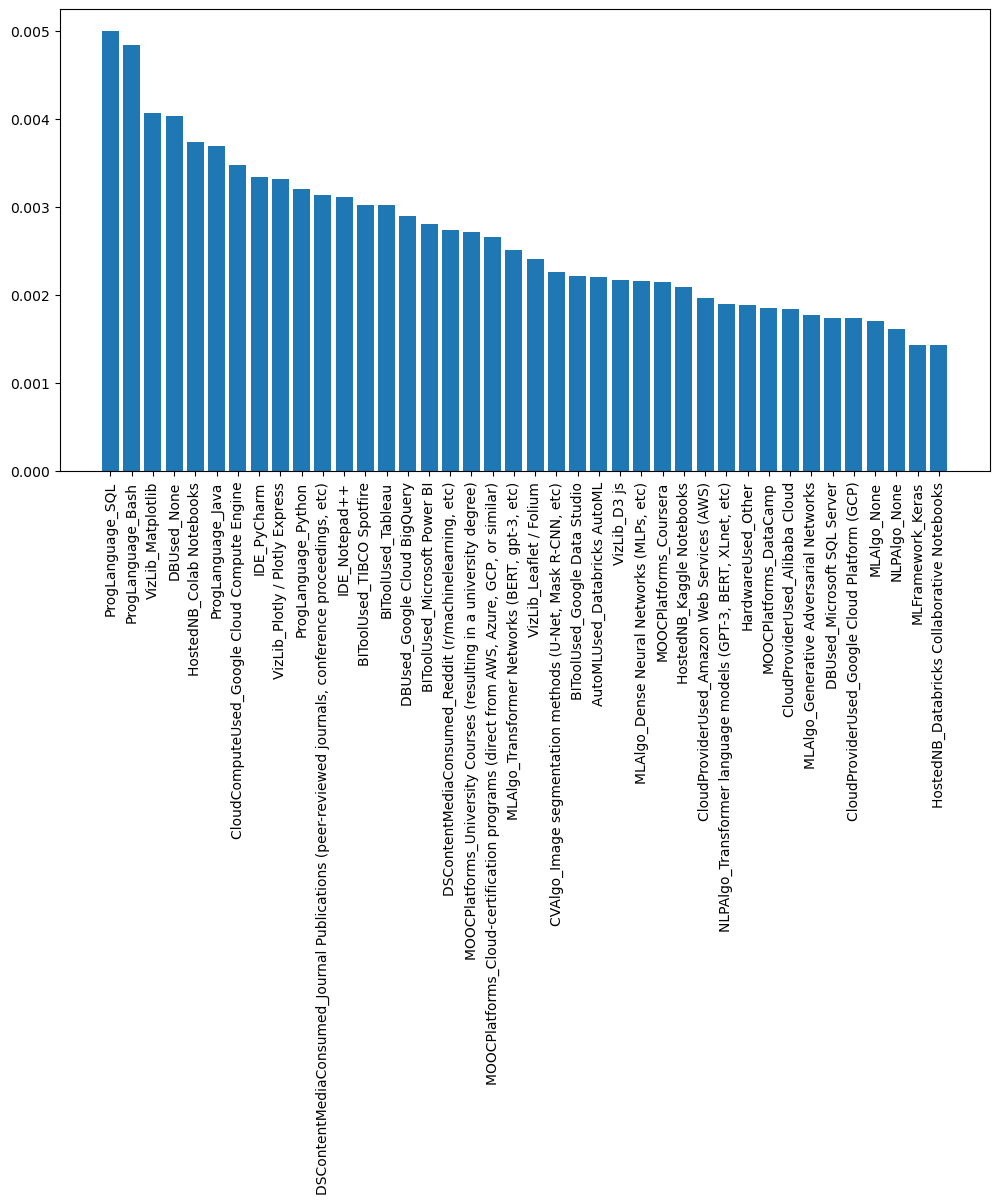

In [561]:
fs = SelectKBest(score_func=mutual_info_classif, k=30)
fs.fit(X, y_de)
# for i in range(len(fs.scores_)):
# 	print('Feature %s: %f' % (X_train.columns[i], fs.scores_[i]))

feat_imp = sorted(list(zip(X.columns, fs.scores_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

plt.figure(figsize=(12,6))
plt.bar(feat_name[:40], feat_imp_score[:40])
plt.xticks(rotation=90);

In [531]:
set(y_train)

{False, True}

In [562]:
X_train, X_test, y_train, y_test = train_test_split(X, y_de,test_size=.2,random_state=seed)

In [563]:
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [564]:
lightgbm1 = LGBMClassifier(**best_model.best_params_, is_unbalance=True, random_state=seed)
lightgbm1.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.5, is_unbalance=True, learning_rate=0.01,
               max_depth=6, n_estimators=800, random_state=42, subsample=0.75)

In [565]:
print(classification_report(y_test, lightgbm1.predict(X_test)))

              precision    recall  f1-score   support

       False       0.96      0.76      0.85      4368
        True       0.12      0.53      0.19       275

    accuracy                           0.74      4643
   macro avg       0.54      0.64      0.52      4643
weighted avg       0.91      0.74      0.81      4643



In [632]:
X, y_de = class_df[NUMERICAL_FEATURES+BINARY_FEATURES], class_df["CurrentTitle"]=="Data Engineer"
X.shape, y_de.shape

((23215, 55), (23215,))

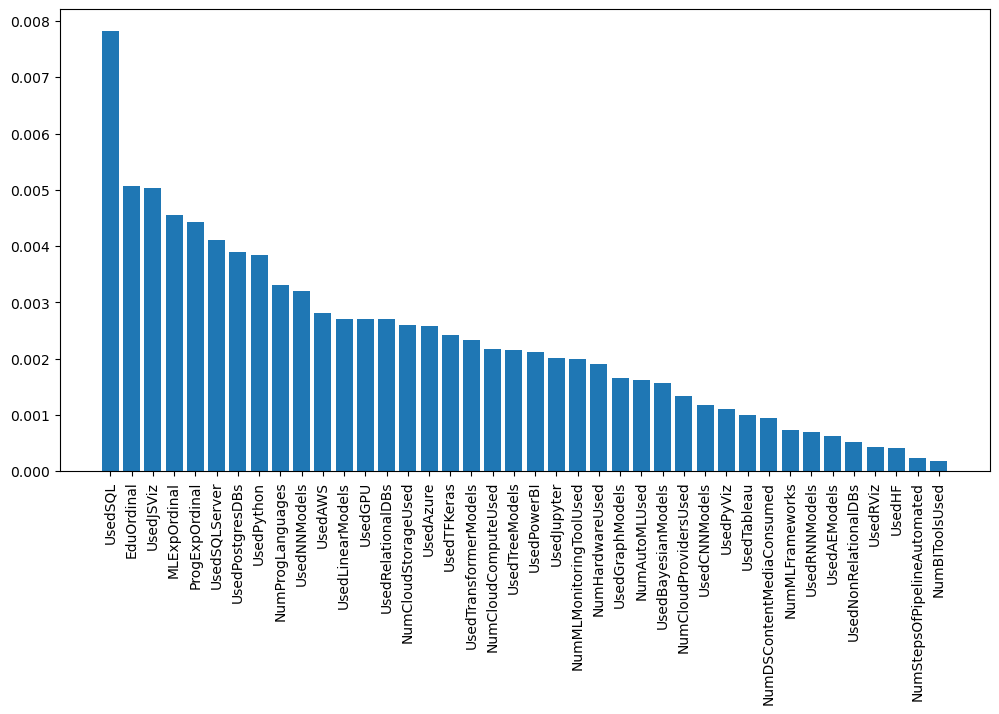

In [633]:
fs = SelectKBest(score_func=mutual_info_classif, k=30)
fs.fit(X, y_de)
# for i in range(len(fs.scores_)):
# 	print('Feature %s: %f' % (X_train.columns[i], fs.scores_[i]))

feat_imp = sorted(list(zip(X.columns, fs.scores_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

plt.figure(figsize=(12,6))
plt.bar(feat_name[:40], feat_imp_score[:40])
plt.xticks(rotation=90);

In [576]:
X_train, X_test, y_train, y_test = train_test_split(X, y_de,test_size=.2,random_state=seed)

In [577]:
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [578]:
lightgbm_de = LGBMClassifier(**best_model.best_params_, is_unbalance=True, random_state=seed)
lightgbm_de.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.5, is_unbalance=True, learning_rate=0.01,
               max_depth=6, n_estimators=800, random_state=42, subsample=0.75)

In [579]:
print(classification_report(y_test, lightgbm_de.predict(X_test)))

              precision    recall  f1-score   support

       False       0.97      0.76      0.85      4368
        True       0.13      0.57      0.21       275

    accuracy                           0.74      4643
   macro avg       0.55      0.66      0.53      4643
weighted avg       0.92      0.74      0.81      4643



In [634]:
class_df["DE_Proba"] = lightgbm_de.predict_proba(fs.transform(X))[:,1]

### Data Scientist

In [627]:
X, y_ds= class_df[NUMERICAL_FEATURES+BINARY_FEATURES], class_df["CurrentTitle"]=="Data Scientist"
X.shape, y_ds.shape

((23215, 55), (23215,))

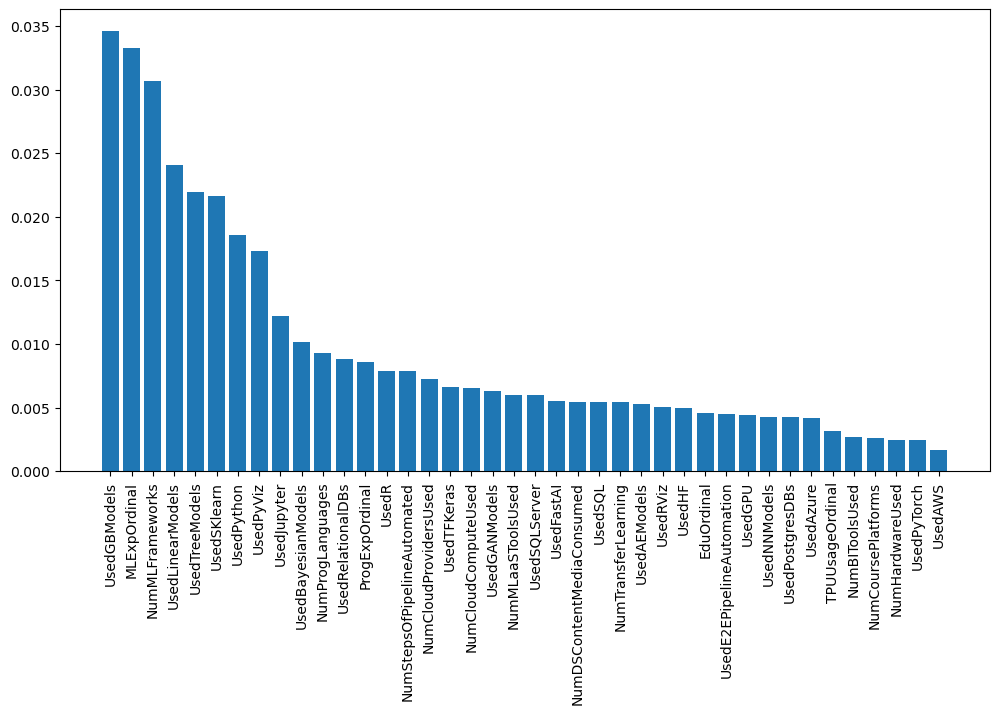

In [628]:
fs = SelectKBest(score_func=mutual_info_classif, k=30)
fs.fit(X, y_ds)
# for i in range(len(fs.scores_)):
# 	print('Feature %s: %f' % (X_train.columns[i], fs.scores_[i]))

feat_imp = sorted(list(zip(X.columns, fs.scores_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

plt.figure(figsize=(12,6))
plt.bar(feat_name[:40], feat_imp_score[:40])
plt.xticks(rotation=90);

In [582]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ds,test_size=.2,random_state=seed)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [583]:
lightgbm_ds = LGBMClassifier(**best_model.best_params_, is_unbalance=True, random_state=seed)
lightgbm_ds.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.5, is_unbalance=True, learning_rate=0.01,
               max_depth=6, n_estimators=800, random_state=42, subsample=0.75)

In [584]:
print(classification_report(y_test, lightgbm_ds.predict(X_test)))

              precision    recall  f1-score   support

       False       0.78      0.69      0.73      2991
        True       0.54      0.65      0.59      1652

    accuracy                           0.68      4643
   macro avg       0.66      0.67      0.66      4643
weighted avg       0.69      0.68      0.68      4643



In [631]:
class_df["DS_Proba"] = lightgbm_ds.predict_proba(fs.transform(X))[:,1]

### Data Analyst

In [624]:
X, y_da= class_df[NUMERICAL_FEATURES+BINARY_FEATURES], class_df["CurrentTitle"]=="Data Analyst"
X.shape, y_da.shape

((23215, 55), (23215,))

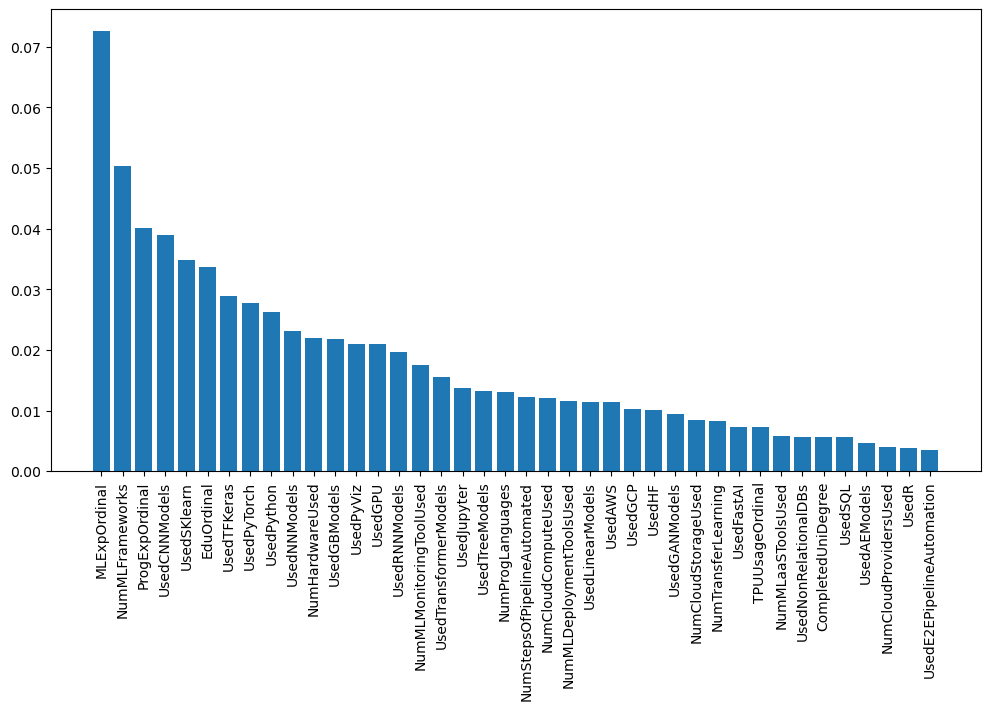

In [625]:
fs = SelectKBest(score_func=mutual_info_classif, k=30)
fs.fit(X, y_da)
# for i in range(len(fs.scores_)):
# 	print('Feature %s: %f' % (X_train.columns[i], fs.scores_[i]))

feat_imp = sorted(list(zip(X.columns, fs.scores_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

plt.figure(figsize=(12,6))
plt.bar(feat_name[:40], feat_imp_score[:40])
plt.xticks(rotation=90);

In [587]:
X_train, X_test, y_train, y_test = train_test_split(X, y_da,test_size=.2,random_state=seed)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [588]:
lightgbm_da = LGBMClassifier(**best_model.best_params_, is_unbalance=True, random_state=seed)
lightgbm_da.fit(X_train, y_train)
print(classification_report(y_test, lightgbm_da.predict(X_test)))

              precision    recall  f1-score   support

       False       0.87      0.71      0.78      3250
        True       0.53      0.75      0.62      1393

    accuracy                           0.72      4643
   macro avg       0.70      0.73      0.70      4643
weighted avg       0.77      0.72      0.73      4643



In [626]:
class_df["DA_Proba"] = lightgbm_da.predict_proba(fs.transform(X))[:,1]

### MLE

In [619]:
X, y_mle = class_df[NUMERICAL_FEATURES+BINARY_FEATURES], class_df["CurrentTitle"]=="Machine Learning Engineer"
X.shape, y_mle.shape

((23215, 55), (23215,))

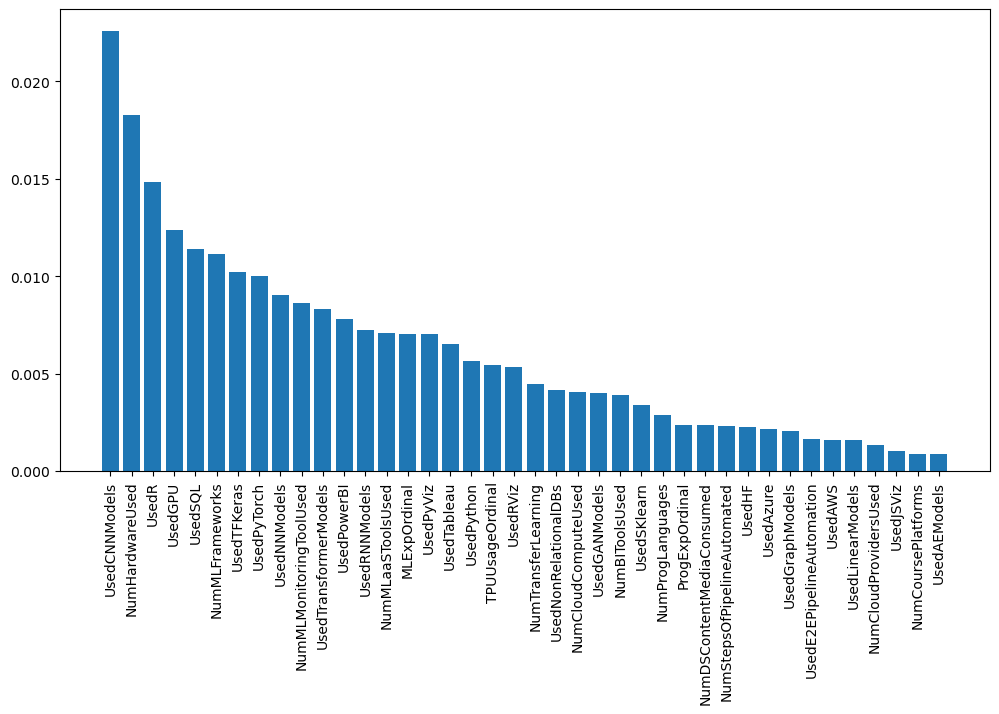

In [620]:
fs = SelectKBest(score_func=mutual_info_classif, k=30)
fs.fit(X, y_mle)
# for i in range(len(fs.scores_)):
# 	print('Feature %s: %f' % (X_train.columns[i], fs.scores_[i]))

feat_imp = sorted(list(zip(X.columns, fs.scores_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

plt.figure(figsize=(12,6))
plt.bar(feat_name[:40], feat_imp_score[:40])
plt.xticks(rotation=90);

In [591]:
X_train, X_test, y_train, y_test = train_test_split(X, y_mle,test_size=.2,random_state=seed)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [592]:
lightgbm_mle = LGBMClassifier(**best_model.best_params_, is_unbalance=True, random_state=seed)
lightgbm_mle.fit(X_train, y_train)
print(classification_report(y_test, lightgbm_mle.predict(X_test)))

              precision    recall  f1-score   support

       False       0.93      0.73      0.82      3993
        True       0.29      0.69      0.41       650

    accuracy                           0.73      4643
   macro avg       0.61      0.71      0.62      4643
weighted avg       0.85      0.73      0.76      4643



In [623]:
class_df["MLE_Proba"] = lightgbm_mle.predict_proba(fs.transform(X))[:,1]

### Research Scientist

In [606]:
X, y_rs = class_df[NUMERICAL_FEATURES+BINARY_FEATURES], class_df["CurrentTitle"]=="Research Scientist"
X.shape, y_rs.shape

((23215, 55), (23215,))

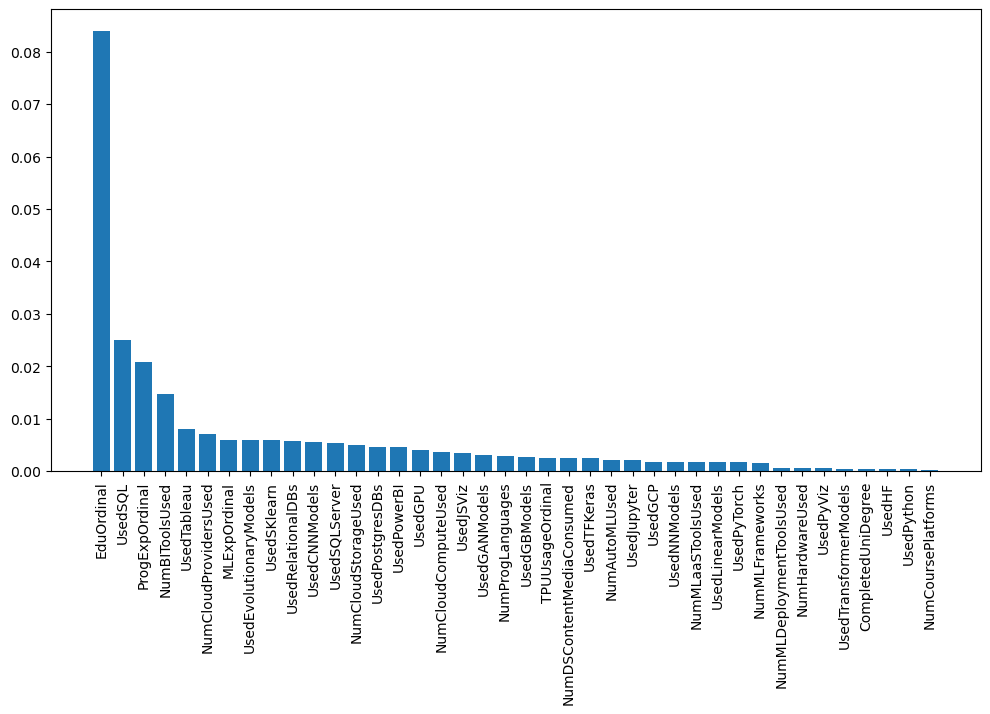

In [607]:
fs = SelectKBest(score_func=mutual_info_classif, k=10)
fs.fit(X, y_rs)
# for i in range(len(fs.scores_)):
# 	print('Feature %s: %f' % (X_train.columns[i], fs.scores_[i]))

feat_imp = sorted(list(zip(X.columns, fs.scores_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

plt.figure(figsize=(12,6))
plt.bar(feat_name[:40], feat_imp_score[:40])
plt.xticks(rotation=90);

In [608]:
X_train, X_test, y_train, y_test = train_test_split(X, y_rs,test_size=.2,random_state=seed)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [597]:
lightgbm_rs = LGBMClassifier(**best_model.best_params_, is_unbalance=True, random_state=seed)
lightgbm_rs.fit(X_train, y_train)
print(classification_report(y_test, lightgbm_rs.predict(X_test)))

              precision    recall  f1-score   support

       False       0.95      0.77      0.85      3970
        True       0.36      0.77      0.49       673

    accuracy                           0.77      4643
   macro avg       0.65      0.77      0.67      4643
weighted avg       0.87      0.77      0.80      4643



In [617]:
class_df["RS_Proba"] = lightgbm_rs.predict_proba(fs.transform(X))[:,1]

In [639]:
X = class_df[["RS_Proba", "DA_Proba", "DS_Proba", "DE_Proba", "MLE_Proba"]]
le = LabelEncoder()
y = le.fit_transform(class_df[TITLE])

In [640]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=seed)

In [641]:
final_estimator = LGBMClassifier(random_state=seed)

In [642]:
final_estimator.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [643]:
print(classification_report(y_test, final_estimator.predict(X_test)))

              precision    recall  f1-score   support

           0       0.53      0.64      0.58      1393
           1       0.04      0.00      0.01       275
           2       0.50      0.63      0.56      1652
           3       0.30      0.09      0.14       650
           4       0.53      0.50      0.51       673

    accuracy                           0.50      4643
   macro avg       0.38      0.37      0.36      4643
weighted avg       0.46      0.50      0.47      4643



In [644]:
f_est = LGBMClassifier(random_state=seed)
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [200, 400, 600, 800]
max_depth = [int(x) for x in np.linspace(1, 6, num = 6)]
subsample = [0.5, 0.75, 1.0]
colsample_bytree = [0.5, 0.75, 1.0]
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree)
clf = RandomizedSearchCV(estimator=f_est, param_distributions=grid, n_iter=50, scoring='accuracy', cv=2, n_jobs=1, verbose=True)


Fitting 2 folds for each of 50 candidates, totalling 100 fits


In [645]:
best_model = clf.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


In [647]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.54      0.68      0.60      1393
           1       0.00      0.00      0.00       275
           2       0.50      0.66      0.57      1652
           3       0.33      0.03      0.06       650
           4       0.54      0.51      0.52       673

    accuracy                           0.52      4643
   macro avg       0.38      0.38      0.35      4643
weighted avg       0.46      0.52      0.47      4643



In [603]:
estimators = [lightgbm_da, lightgbm_de, lightgbm_ds, lightgbm_mle, lightgbm_rs]
sc = StackingClassifier(estimators=estimators, final_estimator=LGBMClassifier(random_state=seed), cv='prefit', stack_method='predict_proba')

In [ ]:
X = class_df[NUMERICAL_FEATURES+BINARY_FEATURES]
le = LabelEncoder()
y = le.fit_transform(class_df[TITLE])


In [ ]:
sc.fit(X_train, y_train).score(X_test, y_test)

In [604]:
sc

StackingClassifier(cv='prefit',
                   estimators=[LGBMClassifier(colsample_bytree=0.5,
                                              is_unbalance=True,
                                              learning_rate=0.01, max_depth=6,
                                              n_estimators=800, random_state=42,
                                              subsample=0.75),
                               LGBMClassifier(colsample_bytree=0.5,
                                              is_unbalance=True,
                                              learning_rate=0.01, max_depth=6,
                                              n_estimators=800, random_state=42,
                                              subsample=0.75),
                               LGBMClassifier(colsample_bytree=0.5,
                                              is_...
                                              subsample=0.75),
                               LGBMClassifier(colsample_bytree=0.5,
                                              is_unbalance=True,
                                              learning_rate=0.01, max_depth=6,
                                              n_estimators=800, random_state=42,
                                              subsample=0.75),
                               LGBMClassifier(colsample_bytree=0.5,
                                              is_unbalance=True,
                                              learning_rate=0.01, max_depth=6,
                                              n_estimators=800, random_state=42,
                                              subsample=0.75)],
                   final_estimator=LGBMClassifier(random_state=42),
                   stack_method='predict_proba')